# AI for Transportation | Recitation 2: Discrete Choice Modeling

In this recitation, we study **Discrete Choice Modeling (DCM)** using both classical baselines and a modern, theory-informed neural network approach: the **Alternative-Specific Utility Deep Neural Network (ASU-DNN)** as presented during lecture and in [this paper by ](https://doi.org/10.1016/j.trc.2020.01.012). Our goal is to understand how a utility-theoretic structure can guide neural architectures to achieve **better prediction**, **clearer interpretation**, and **stronger generalization** than a simple logistic baseline, a multinomial logit model, and a fully connected DNN architecture.

We will work with the [1987 Netherlands **Train**](https://open.rijkswaterstaat.nl/@120703/the-netherlands-value-time-study-final/) mode-choice dataset which is distributed by the [**mlogit**](https://cran.r-project.org/web/packages/mlogit/index.html) R package. You can find information on the dataset in the mlogit [documentation](https://www.rdocumentation.org/packages/mlogit/versions/0.2-4/topics/Train) as well as [this document](https://drive.google.com/file/d/17BR1nNP3Cjca3_YjA3aH_BD-e-ov1z83/view?usp=drive_link), which is the original report explaining the data sampling process.

We will proceed in four parts:

1. **Data Access & Preparation**  
   - Import the `Train` dataset and convert it to long/choice-format using `pandas`.  
   - Define a k-fold cross validation data split into train/test sets with traveler-level grouping.

2. **Classical Baselines (Utility Models)**  
   - Fit a **Regression** model
   - Fit **Multinomial Logit (MNL)** with alternative-specific constants and key attributes (time, cost, etc.).  
   - Report **in-sample fit** and **out-of-sample accuracy**.  
   - Extract **elasticities**, **value of time (VOT)**, and **substitution patterns** for interpretability.

3. **ASU-DNN (Theory-Guided Architecture)**  
   - Build a sparse, **alternative-specific** network where each alternative's attributes feed only its own utility head (softmax over utilities).  
   - Train with cross-entropy; compare against a **Fully Connected (FC) DNN** of similar capacity.  
   - Evaluate **accuracy**, **calibration**, and **interpretability** (e.g., cost/time response curves per mode).

4. **Comparison & Reflection**  
   - Side-by-side results for **MNL vs. FC-DNN vs. ASU-DNN**.  
   - Discuss the trade-off between **approximation power** and **estimation stability**, and how ASU-DNN acts as a **domain-knowledge regularizer**.  

By the end, we will:
- Load and prepare a **choice-format** dataset
- Fit and interpret a **simple Logistic Regression**, and **classical MNL** model.  
- Implement and train a **fully-connected DNN** and a **theory-informed ASU-DNN**, comparing them with the other models.
- Analyze the results

In [2]:
# Essential imports for data manipulation and analysis
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score
from sklearn.pipeline import Pipeline

# Deep learning imports
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks

# Statistical analysis
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.special import logsumexp

# Random state variable to use
RANDOM_STATE = 32345425

# Display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("Dark2")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Device Selection
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

Using device: /GPU:0


## Data Loading

In [3]:
!gdown 1n_thf9fWac4cpgmp2VjCjB8Z98H4zbrs

Downloading...
From: https://drive.google.com/uc?id=1n_thf9fWac4cpgmp2VjCjB8Z98H4zbrs
To: /content/mlogit_Train_wide.csv
100% 122k/122k [00:00<00:00, 93.9MB/s]


In [4]:
# Load the data using pandas
df_raw = pd.read_csv('./mlogit_Train_wide.csv')

# Display basic info about the dataset
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

# First, let's see what columns we actually have
print(f"Dataset shape: {df_raw.shape[0]:,} observations × {df_raw.shape[1]} variables")

display(df_raw.head(8))

# Use the actual column names from the dataset
id_col = df_raw.columns[0] if len(df_raw.columns) > 0 else None
choice_col = 'choice' if 'choice' in df_raw.columns else df_raw.columns[2] if len(df_raw.columns) > 2 else None

print(f"\nVariable Summary:")
print(f"- Individual identifiers: {df_raw[id_col].nunique():,} unique individuals")
per_person = df_raw.groupby('id')['choiceid'].nunique()
print(f"- Avg scenarios per individual: {per_person.mean():.2f} "
      f"(median {per_person.median()}, min {per_person.min()}, max {per_person.max()})")
print(f"- Total choice observations: {len(df_raw):,}")

# Check the choice distribution
choice_dist = df_raw[choice_col].value_counts()
print(f"\n Choice Distribution:")
for choice, count in choice_dist.items():
    percentage = (count / len(df_raw)) * 100
    print(f"- {choice}: {count:,} ({percentage:.1f}%)")


DATASET OVERVIEW
Dataset shape: 2,929 observations × 11 variables


,id,choiceid,choice,price1,time1,change1,comfort1,price2,time2,change2,comfort2
0,1,1,choice1,2400,150,0,1,4000,150,0,1
1,1,2,choice1,2400,150,0,1,3200,130,0,1
2,1,3,choice1,2400,115,0,1,4000,115,0,0
3,1,4,choice2,4000,130,0,1,3200,150,0,0
4,1,5,choice2,2400,150,0,1,3200,150,0,0
5,1,6,choice2,4000,115,0,0,2400,130,0,0
6,1,7,choice2,2400,150,0,1,3200,115,0,1
7,1,8,choice2,2400,115,0,1,3200,150,0,0



Variable Summary:
- Individual identifiers: 235 unique individuals
- Avg scenarios per individual: 12.46 (median 13.0, min 5, max 19)
- Total choice observations: 2,929

 Choice Distribution:
- choice1: 1,474 (50.3%)
- choice2: 1,455 (49.7%)


### Variable Overview

| Variable   | Description                                                                 |
|------------|-----------------------------------------------------------------------------|
| id         | individual identifier                                                       |
| choiceid   | choice identifier                                                           |
| choice     | one of choice1, choice2                                                     |
| pricez     | price of proposition z (z = 1, 2) in cents of guilders                      |
| timez      | travel time of proposition z (z = 1, 2) in minutes                          |
| comfortz   | comfort of proposition z (z = 1, 2), values 0, 1, or 2 (decreasing comfort) |
| changez    | number of changes for proposition z (z = 1, 2)                              |

### Important

Keep in mind, that (ASC being the Alternative-Specific Constant):
- **Alternative 1 (base, ASC normalized to 0) = Car**
- **Alternative 2 (ASC[j=2]) = Train**

### Basic statistics
The dataset has **no missing values** and here are some statistics:

*Comfort Level Distribution:* (0 = highest comfort, 2 = lowest comfort)
- Alternative 1 comfort levels:
    - Level 0 (High): **693 (23.7%)**
    - Level 1 (Medium): **1,839 (62.8%)**
    - Level 2 (Low): **397 (13.6%)**
- Alternative 2 comfort levels:
    - Level 0 (High): **743 (25.4%)**
    - Level 1 (Medium): **1,780 (60.8%)**
    - Level 2 (Low): **406 (13.9%)**

*Choice Structure Analysis:*
- Total observations: **2,929**
- Unique choice scenarios (choiceid): **19**
- Average scenarios per individual: **154.2**
- Choice scenarios range: **1 to 234 per individual**
- Most individuals have: **233 choice scenarios**

### Long format transformation

The dataset is currently in **wide format** where each row represents a choice scenario with attributes for all alternatives in separate columns: `price1, time1, comfort1, change1, price2, time2, comfort2, change2` .

For discrete choice modeling, we need to convert it to **long format** where:
- Each row represents a single alternative within a choice scenario
- All alternatives from the same choice scenario share the same `obs_id`
- Each alternative has its own set of attributes (price, time, comfort, change)
- A binary `chosen` variable indicates which alternative was selected

**Example transformation:**
```
Wide format (1 row per choice scenario):
id=1, choiceid=1, choice=choice1, price1=2400, time1=150, price2=4000, time2=150

Long format (2 rows per choice scenario):
obs_id='1_1', alternative=1, price=2400, time=150, chosen=1
obs_id='1_1', alternative=2, price=4000, time=150, chosen=0
```

This format allows us to:
1. Apply the same model to all alternatives
2. Handle varying numbers of alternatives per choice scenario
3. Easily compute utilities and choice probabilities

In [5]:
def wide_to_long_format(df_wide):
    """
    Convert the wide format dataset to long format suitable for discrete choice modeling.

    Parameters:
    -----------
    df_wide : pd.DataFrame
        Wide format data with columns: id, choiceid, choice, price1, time1, comfort1, change1, price2, time2, comfort2, change2

    Returns:
    --------
    pd.DataFrame
        Long format data with columns: obs_id, alternative, price, time, comfort, change, chosen
    """
    long_data = []

    for idx, row in df_wide.iterrows():
        # Create unique observation identifier
        obs_id = f"{row['id']}_{row['choiceid']}"

        # Determine which alternative was chosen (choice1 = alternative 1, choice2 = alternative 2)
        chosen_alt = 1 if row['choice'] == 'choice1' else 2

        # Add alternative 1
        long_data.append({
            'obs_id': obs_id,
            'individual_id': row['id'],
            'choice_scenario': row['choiceid'],
            'alternative': 1,
            'price': row['price1'],
            'time': row['time1'],
            'comfort': row['comfort1'],
            'change': row['change1'],
            'chosen': 1 if chosen_alt == 1 else 0
        })

        # Add alternative 2
        long_data.append({
            'obs_id': obs_id,
            'individual_id': row['id'],
            'choice_scenario': row['choiceid'],
            'alternative': 2,
            'price': row['price2'],
            'time': row['time2'],
            'comfort': row['comfort2'],
            'change': row['change2'],
            'chosen': 1 if chosen_alt == 2 else 0
        })

    return pd.DataFrame(long_data)

In [6]:
# Perform the transformation
df_long = wide_to_long_format(df_raw)

print("="*60)
print("LONG FORMAT TRANSFORMATION RESULTS")
print("="*60)

print(f"Original wide format: {df_raw.shape[0]:,} choice scenarios")
print(f"New long format: {df_long.shape[0]:,} alternative-choice observations")
print(f"Expected: {df_raw.shape[0] * 2:,} (2 alternatives per choice scenario)")

print(f"\nLong format columns: {list(df_long.columns)}")

# Display sample of long format data
print(f"\nSample of long format data:")
display(df_long.head(10))

# Verify the transformation
print(f"\nVerification:")
print(f"- Unique observation IDs: {df_long['obs_id'].nunique():,}")
print(f"- Choice scenarios in wide format: {df_raw.shape[0]:,}")
print(f"- Alternatives per choice scenario: {df_long.groupby('obs_id').size().unique()}")

# Check choice distribution
choice_counts = df_long['chosen'].value_counts()
print(f"\nChoice distribution in long format:")
print(f"- Chosen (1): {choice_counts[1]:,} ({choice_counts[1]/len(df_long)*100:.1f}%)")
print(f"- Not chosen (0): {choice_counts[0]:,} ({choice_counts[0]/len(df_long)*100:.1f}%)")

# Display basic statistics for the attributes
print(f"\nAttribute statistics:")
display(df_long[['price', 'time', 'comfort', 'change']].describe())

LONG FORMAT TRANSFORMATION RESULTS
Original wide format: 2,929 choice scenarios
New long format: 5,858 alternative-choice observations
Expected: 5,858 (2 alternatives per choice scenario)

Long format columns: ['obs_id', 'individual_id', 'choice_scenario', 'alternative', 'price', 'time', 'comfort', 'change', 'chosen']

Sample of long format data:


,obs_id,individual_id,choice_scenario,alternative,price,time,comfort,change,chosen
0,1_1,1,1,1,2400,150,1,0,1
1,1_1,1,1,2,4000,150,1,0,0
2,1_2,1,2,1,2400,150,1,0,1
3,1_2,1,2,2,3200,130,1,0,0
4,1_3,1,3,1,2400,115,1,0,1
5,1_3,1,3,2,4000,115,0,0,0
6,1_4,1,4,1,4000,130,1,0,0
7,1_4,1,4,2,3200,150,0,0,1
8,1_5,1,5,1,2400,150,1,0,0
9,1_5,1,5,2,3200,150,0,0,1



Verification:
- Unique observation IDs: 2,929
- Choice scenarios in wide format: 2,929
- Alternatives per choice scenario: [2]

Choice distribution in long format:
- Chosen (1): 2,929 (50.0%)
- Not chosen (0): 2,929 (50.0%)

Attribute statistics:


,price,time,comfort,change
count,5858.000000,5858.000000,5858.000000,5858.000000
mean,3367.548651,127.318197,0.891943,0.672414
std,1285.427707,28.572248,0.608769,0.737813
min,100.000000,55.000000,0.000000,0.000000
25%,2500.000000,107.000000,1.000000,0.000000
50%,3215.000000,125.000000,1.000000,1.000000
75%,4000.000000,145.000000,1.000000,1.000000
max,12500.000000,250.000000,2.000000,4.000000


## Models

### Logistic Regression

**Logistic Regression** serves as our simplest baseline model. It treats the choice as a binary classification problem by considering the **differences** between alternatives rather than their individual utilities.

**Model Structure:**
- **Input**: Difference features (price₂ - price₁, time₂ - time₁, etc.)
- **Output**: Probability of choosing alternative 2 over alternative 1
- **Assumption**: The log-odds of choosing alternative 2 is linear in the difference features

**Mathematical Formulation:**
```
P(choice = alt2) = σ(β₀ + β₁·Δprice + β₂·Δtime + β₃·Δcomfort + β₄·Δchange)
```

Where:
- σ is the sigmoid function
- Δfeature = feature₂ - feature₁
- β coefficients represent the impact of feature differences on choice probability

**Parameters:**
- `C=1.0`: Regularization strength (lower values = stronger regularization)
- `max_iter=1000`: Maximum iterations for convergence
- `random_state=42`: For reproducible results
- `solver='lbfgs'`: Optimization algorithm (good for small datasets)

In [7]:
class SimpleLogisticBaseline:
    """
    Simple logistic regression for binary choice modeling using difference features.
    Treats choice as classification between two alternatives.
    """

    def __init__(self, C=1.0, max_iter=1000, random_state=42):
        """
        Initialize the logistic regression model.

        Parameters:
        -----------
        C : float, default=1.0
            Regularization strength (inverse of regularization parameter)
        max_iter : int, default=1000
            Maximum number of iterations for the solver to converge
        random_state : int, default=42
            Random state for reproducibility
        """
        self.C = C
        self.max_iter = max_iter
        self.random_state = random_state
        self.model = LogisticRegression(
            C=self.C,
            max_iter=self.max_iter,
            random_state=self.random_state,
            solver='lbfgs'
        )
        self.fitted_ = False

    def _create_difference_features(self, df_long):
        """Convert long format to difference features for binary classification."""
        # Group by observation to get both alternatives
        grouped = df_long.groupby('obs_id')

        diff_data = []
        for obs_id, group in grouped:
            if len(group) != 2:
                continue  # Skip if not exactly 2 alternatives

            # Sort by alternative to ensure consistent ordering
            group = group.sort_values('alternative')
            alt1, alt2 = group.iloc[0], group.iloc[1]

            # Create difference features (alt2 - alt1)
            diff_features = {
                'obs_id': obs_id,
                'price_diff': alt2['price'] - alt1['price'],
                'time_diff': alt2['time'] - alt1['time'],
                'comfort_diff': alt2['comfort'] - alt1['comfort'],
                'change_diff': alt2['change'] - alt1['change'],
                'chosen_alt2': alt2['chosen']  # 1 if alt2 chosen, 0 if alt1 chosen
            }
            diff_data.append(diff_features)

        return pd.DataFrame(diff_data)

    def fit(self, X_long, y_long, obs_ids, alternatives):
        """
        Fit the logistic regression model using difference features.

        Parameters:
        -----------
        X_long : array-like
            Feature matrix in long format (not used directly)
        y_long : array-like
            Choice indicators in long format (not used directly)
        obs_ids : array-like
            Observation identifiers
        alternatives : array-like
            Alternative identifiers
        """
        # Create DataFrame from inputs
        df_temp = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'price': X_long[:, 0],
            'time': X_long[:, 1],
            'comfort': X_long[:, 2],
            'change': X_long[:, 3],
            'chosen': y_long
        })

        # Convert to difference features
        df_diff = self._create_difference_features(df_temp)

        # Prepare features and target
        feature_cols = ['price_diff', 'time_diff', 'comfort_diff', 'change_diff']
        X = df_diff[feature_cols].values
        y = df_diff['chosen_alt2'].values

        # Fit the model
        self.model.fit(X, y)
        self.fitted_ = True

        # Store feature names for interpretation
        self.feature_names_ = feature_cols

        return self

    def predict_proba(self, X_long, obs_ids, alternatives):
        """
        Predict choice probabilities.

        Returns probabilities aligned with the input rows.
        """
        if not self.fitted_:
            raise ValueError("Model must be fitted before prediction")

        # Create DataFrame from inputs
        df_temp = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'price': X_long[:, 0],
            'time': X_long[:, 1],
            'comfort': X_long[:, 2],
            'change': X_long[:, 3],
            'chosen': np.zeros(len(X_long))  # Dummy values for prediction
        })

        # Convert to difference features
        df_diff = self._create_difference_features(df_temp)

        if len(df_diff) == 0:
            return np.full(len(X_long), 0.5)

        # Get predictions
        feature_cols = ['price_diff', 'time_diff', 'comfort_diff', 'change_diff']
        X = df_diff[feature_cols].values
        proba_alt2 = self.model.predict_proba(X)[:, 1]  # Probability of choosing alt2

        # Map back to original format
        probs = np.full(len(X_long), 0.5)

        # Create mapping from obs_id to probability
        obs_to_prob = dict(zip(df_diff['obs_id'], proba_alt2))

        for i, (obs_id, alt) in enumerate(zip(obs_ids, alternatives)):
            if obs_id in obs_to_prob:
                if alt == 1:
                    probs[i] = 1 - obs_to_prob[obs_id]  # P(alt1) = 1 - P(alt2)
                else:
                    probs[i] = obs_to_prob[obs_id]      # P(alt2)

        return probs

    def get_coefficients(self):
        """Get model coefficients for interpretation."""
        if not self.fitted_:
            raise ValueError("Model must be fitted first")

        coef_df = pd.DataFrame({
            'Feature': self.feature_names_,
            'Coefficient': self.model.coef_[0],
            'Abs_Coefficient': np.abs(self.model.coef_[0])
        })
        coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

        return coef_df

    def count_parameters(self):
        """
        Return the total number of trainable and non-trainable parameters in the logistic baseline.
        """
        if not self.fitted_ or not hasattr(self.model, "coef_"):
            raise ValueError("Model has not been fitted yet. Call fit() first.")

        n_coeff = int(self.model.coef_.size)
        n_intercept = int(self.model.intercept_.size) if hasattr(self.model, "intercept_") else 0
        n_total = n_coeff + n_intercept

        return {
            'trainable_parameters': n_total,
            'non_trainable_parameters': 0,
            'total_parameters': n_total
        }

In [8]:
logistic_model = SimpleLogisticBaseline(
    C=1.0,                      # Regularization strength
    max_iter=1000,              # Maximum iterations
    random_state=RANDOM_STATE   # For reproducibility
)

print("Logistic Regression model initialized with parameters:")
print(f"   - Regularization strength (C): {logistic_model.C}")
print(f"   - Maximum iterations: {logistic_model.max_iter}")
print(f"   - Random state: {logistic_model.random_state}")
print(f"   - Solver: lbfgs")

Logistic Regression model initialized with parameters:
   - Regularization strength (C): 1.0
   - Maximum iterations: 1000
   - Random state: 32345425
   - Solver: lbfgs


### Multinomial Logit Model (MNL)

The **Multinomial Logit Model** is the gold standard for discrete choice modeling, based on **Random Utility Theory**. It models the utility of each alternative as a linear function of its attributes plus a random error term.

**Theoretical Foundation:**
- Each alternative j has utility: `U_j = V_j + ε_j`
- Systematic utility: `V_j = β₀_j + β₁·price_j + β₂·time_j + β₃·comfort_j + β₄·change_j`
- Random error `ε_j` follows Type I Extreme Value distribution ([Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution))

**Choice Probability (Softmax):**
```
P(alternative j) = exp(V_j) / Σ_k exp(V_k)
```

**Key Properties:**
- **IIA Assumption**: Independence of Irrelevant Alternatives
- **Interpretable coefficients**: `β₁ < 0` means higher price reduces utility
- **Value of Time**: `VOT = -β_time / β_price` (willingness to pay for time savings)
- **Alternative-Specific Constants**: Capture unobserved preferences

**Model Parameters:**
- `include_constants=True`: Include alternative-specific constants (i.e. `β₀_j`)
- `scale=False`: Don't standardize features (preserves interpretability but can worsen results)
- `maxiter=1000`: Maximum optimization iterations
- `random_state=42`: For reproducible results

**Advantages:**
- Well-established theoretical foundation
- Highly interpretable coefficients
- Provides economic insights (elasticities, VOT, etc.)
- Fast computation and convergence

In [9]:
class MultinomialLogit:
    """
    Multinomial Logit model (MNL) for discrete choice analysis based on Random Utility Theory.

    The utility function for alternative j is:
    U_j = β₀_j + β₁*price_j + β₂*time_j + β₃*comfort_j + β₄*change_j + ε_j

    Where ε_j follows a Type I Extreme Value distribution.
    """

    def __init__(self, include_constants=True, scale=True, random_state=42, maxiter=1000):
        """
        Initialize the Multinomial Logit model.

        Parameters:
        -----------
        include_constants : bool, default=True
            Whether to include alternative-specific constants
        scale : bool, default=False
            Whether to standardize features (False preserves interpretability)
        random_state : int, default=42
            Random seed for reproducibility
        maxiter : int, default=1000
            Maximum iterations for optimization
        """
        self.include_constants = include_constants
        self.scale = scale
        self.random_state = random_state
        self.max_iter = maxiter
        self.params = None
        self.param_names = None
        self.log_likelihood = None
        self.fitted_ = False
        self.scaler_ = None
        self.n_alts_ = None
        self.n_features_ = None
        self.groups_ = None

    @staticmethod
    def _build_groups(obs_ids):
        """Return list of index arrays, one per choice set."""
        obs_ids = np.asarray(obs_ids)
        groups = []
        for obs in np.unique(obs_ids):
            idx = np.flatnonzero(obs_ids == obs)
            if idx.size >= 2:
                groups.append(idx)
        return groups

    def _split_params(self, params):
        """Split parameters into ASCs and betas."""
        if self.include_constants:
            asc = params[:self.n_alts_ - 1]
            beta = params[self.n_alts_ - 1:]
        else:
            asc = np.zeros(self.n_alts_ - 1)
            beta = params
        return asc, beta

    def _utilities_for_group(self, asc, beta, Xg, altg):
        """Compute utilities for a group."""
        u = Xg @ beta
        add = np.zeros(len(altg), dtype=float)
        mask = (altg > 1)
        add[mask] = asc[altg[mask] - 2]
        return u + add

    def _neg_loglik_and_grad(self, params, X, y, obs_ids, alternatives):
        """Compute negative log-likelihood and gradient for multinomial logit."""

        # Split parameter vector into alternative-specific constants (ASC) and betas
        asc, beta = self._split_params(params)

        # Initialize total log-likelihood and gradients
        total_ll = 0.0
        grad_asc = np.zeros(self.n_alts_ - 1)   # exclude base alternative
        grad_beta = np.zeros(self.n_features_)  # gradient wrt feature coefficients

        # Loop over groups (choice situations / observation sets)
        for idx in self.groups_:
            Xg = X[idx]              # feature matrix for this choice set
            yg = y[idx]              # binary choice indicators (one chosen alternative)
            altg = alternatives[idx] # alternative IDs for this set

            # Skip invalid groups (must have exactly one chosen alternative)
            if yg.sum() != 1:
                continue

            # Compute systematic utilities for this group
            ug = self._utilities_for_group(asc, beta, Xg, altg)

            # Numerical stabilization: subtract max before exponentiation
            ug_max = np.max(ug)
            ug_stable = ug - ug_max
            exp_u = np.exp(ug_stable)
            sum_exp_u = np.sum(exp_u)

            # Contribution to log-likelihood (log-softmax trick)
            chosen_idx = np.where(yg == 1)[0][0]
            total_ll += ug_stable[chosen_idx] - np.log(sum_exp_u)

            # Compute choice probabilities (softmax)
            probs = exp_u / sum_exp_u

            # Gradient wrt beta: observed features minus expected features
            grad_beta += Xg[chosen_idx] - np.sum(probs[:, np.newaxis] * Xg, axis=0)

            # Gradient wrt alternative-specific constants (if included)
            if self.include_constants:
                for j, alt in enumerate(altg):
                    if alt > 1:  # base alternative (alt=1) is reference, no ASC
                        asc_idx = alt - 2
                        if j == chosen_idx:
                            grad_asc[asc_idx] += 1.0  # indicator for chosen ASC
                        grad_asc[asc_idx] -= probs[j] # subtract expected ASC count

        # Concatenate gradients into a single vector
        if self.include_constants:
            grad = np.concatenate([grad_asc, grad_beta])
        else:
            grad = grad_beta

        # Return negative log-likelihood and its gradient (for minimization)
        return -total_ll, -grad

    def fit(self, X, y, obs_ids, alternatives):
        """
        Fit the Multinomial Logit model.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix
        y : array-like, shape (n_samples,)
            Choice indicators (1 if chosen, 0 otherwise)
        obs_ids : array-like, shape (n_samples,)
            Observation identifiers
        alternatives : array-like, shape (n_samples,)
            Alternative identifiers
        """
        X = np.asarray(X, float)
        y = np.asarray(y, int)
        obs_ids = np.asarray(obs_ids)
        alternatives = np.asarray(alternatives, int)

        if self.scale:
            self.scaler_ = StandardScaler().fit(X)
            Xs = self.scaler_.transform(X)
        else:
            Xs = X

        # Normalize alternatives to 1..J
        unique_alts = np.sort(np.unique(alternatives))
        alt_map = {a: i + 1 for i, a in enumerate(unique_alts)}
        alt_norm = np.vectorize(alt_map.get)(alternatives)
        self.n_alts_ = len(unique_alts)

        if self.include_constants:
            # base alternative is the first in unique_alts (mapped to 1)
            asc_names = [f"ASC[{a}]" for a in unique_alts[1:]]  # skip base alt
            feature_names = getattr(self, "feature_names_", None)
            if feature_names is None:
                # fallback generic names if user didn't set them
                feature_names = [f"x{i}" for i in range(Xs.shape[1])]
            self.param_names = asc_names + feature_names
        else:
            feature_names = getattr(self, "feature_names_", None)
            if feature_names is None:
                feature_names = [f"x{i}" for i in range(Xs.shape[1])]
            self.param_names = feature_names

        # Build groups
        groups = self._build_groups(obs_ids)
        good_groups = []
        for idx in groups:
            if y[idx].sum() == 1 and len(idx) >= 2:
                good_groups.append(idx)

        if len(good_groups) == 0:
            raise ValueError("No valid choice sets found.")

        self.groups_ = good_groups
        self.n_features_ = Xs.shape[1]

        # Parameter setup
        if self.include_constants:
            n_params = (self.n_alts_ - 1) + self.n_features_
        else:
            n_params = self.n_features_

        # Try multiple optimization strategies
        methods = ['L-BFGS-B', 'BFGS']
        best_result = None

        for method in methods:
            for init_scale in [0.01, 0.1]:
                try:
                    np.random.seed(self.random_state)
                    init_params = np.random.normal(0, init_scale, n_params)

                    def objective(params):
                        return self._neg_loglik_and_grad(params, Xs, y, obs_ids, alt_norm)

                    bounds = [(-10, 10) for _ in range(n_params)] if method == 'L-BFGS-B' else None

                    result = minimize(
                        fun=objective,
                        x0=init_params,
                        method=method,
                        jac=True,
                        bounds=bounds,
                        options={'maxiter': self.max_iter, 'disp': False}
                    )

                    if result.success and (best_result is None or result.fun < best_result.fun):
                        best_result = result

                    if result.success:
                        break

                except:
                    continue

            if best_result is not None and best_result.success:
                break

        if best_result is not None and best_result.success:
            self.params = best_result.x
            self.log_likelihood = -best_result.fun
            self.fitted_ = True
            return self
        else:
            self.fitted_ = False
            raise ValueError("MNL optimization failed with all methods")

    def predict_proba(self, X, obs_ids, alternatives):
        """Predict choice probabilities."""
        if not self.fitted_:
            raise ValueError("Model must be fitted first")

        X = np.asarray(X, float)
        if self.scale and self.scaler_ is not None:
            Xs = self.scaler_.transform(X)
        else:
            Xs = X

        asc, beta = self._split_params(self.params)
        probs = np.full(len(X), 0.5)

        # Normalize alternatives
        unique_alts = np.sort(np.unique(alternatives))
        alt_map = {a: i + 1 for i, a in enumerate(unique_alts)}
        alt_norm = np.vectorize(alt_map.get)(alternatives)

        groups = self._build_groups(obs_ids)
        for idx in groups:
            if len(idx) >= 2:
                Xg = Xs[idx]
                altg = alt_norm[idx]
                ug = self._utilities_for_group(asc, beta, Xg, altg)
                exp_u = np.exp(ug - np.max(ug))
                group_probs = exp_u / np.sum(exp_u)
                probs[idx] = group_probs

        return probs

    def count_parameters(self):
        """
        Return the total number of trainable and non-trainable parameters in the MNL model.
        """
        if self.params is None:
            raise ValueError("Model has not been fitted yet. Call fit() first.")

        n_total = int(self.params.size)
        return {
            'trainable_parameters': n_total,
            'non_trainable_parameters': 0,
            'total_parameters': n_total
        }

    def summary(self):
        if not self.fitted_:
            raise ValueError("Model must be fitted first")
        import pandas as pd
        n_params = len(self.params)
        n_obs = sum(len(g) for g in self.groups_)
        ll = self.log_likelihood
        aic = 2 * n_params - 2 * ll
        bic = np.log(n_obs) * n_params - 2 * ll

        # fallback names if not set or wrong length
        names = self.param_names
        if (names is None) or (len(names) != n_params):
            if self.include_constants:
                # try to reconstruct something sensible
                asc_names = [f"ASC[j={j}]" for j in range(2, self.n_alts_ + 1)]
                p = n_params - (self.n_alts_ - 1)
                beta_names = getattr(self, "feature_names_", None)
                if (beta_names is None) or (len(beta_names) != p):
                    beta_names = [f"beta_{i}" for i in range(p)]
                names = asc_names + beta_names
            else:
                p = n_params
                beta_names = getattr(self, "feature_names_", None)
                if (beta_names is None) or (len(beta_names) != p):
                    beta_names = [f"beta_{i}" for i in range(p)]
                names = beta_names

        print("============================================================")
        print("MULTINOMIAL LOGIT (MNL) MODEL SUMMARY")
        print("============================================================")
        print(f"Log-Likelihood = {ll:.3f}")
        print(f"AIC = {aic:.2f} | BIC = {bic:.2f}")
        print("------------------------------------------------------------")
        print("Parameters:")
        df = pd.DataFrame({"Parameter": names, "Estimate": self.params})
        print(df.to_string(index=False))
        print("============================================================")

In [10]:
mnl_model = MultinomialLogit(
    include_constants=True,     # Include alternative-specific constants
    scale=False,                # Don't scale features (preserves interpretability)
    random_state=RANDOM_STATE,  # For reproducibility
    maxiter=1000                # Maximum optimization iterations
)

print("Multinomial Logit model initialized with parameters:")
print(f"   - Include constants: {mnl_model.include_constants}")
print(f"   - Scale features: {mnl_model.scale}")
print(f"   - Maximum iterations: {mnl_model.max_iter}")
print(f"   - Random state: {mnl_model.random_state}")
print("\nModel will estimate:")
print("   - 4 utility coefficients (price, time, comfort, change)")
print("   - 1 alternative-specific constant (alt2 relative to alt1)")
print("   - Total parameters: 5")

Multinomial Logit model initialized with parameters:
   - Include constants: True
   - Scale features: False
   - Maximum iterations: 1000
   - Random state: 32345425

Model will estimate:
   - 4 utility coefficients (price, time, comfort, change)
   - 1 alternative-specific constant (alt2 relative to alt1)
   - Total parameters: 5


## Fully Connected Deep Neural Network (FC-DNN)

The FC-DNN model replaces the traditional logit approach by using deep neural networks to capture complex non-linear relationships in the data. Unlike the linear utility functions in MNL, FC-DNN can model:

- **Non-linear relationships** between attributes and utilities
- **Complex interaction effects** between different features
- **Flexible functional forms** without assuming specific mathematical relationships

### Model Architecture:
- **Input Layer**: Features for all alternatives concatenated
- **Hidden Layers**: Multiple fully connected layers with ReLU activation
- **Output Layer**: Utilities for each alternative (softmax for probabilities)

### Key Advantages:
- Can capture complex patterns that linear models miss
- Automatically learns feature interactions
- No need to manually specify interaction terms

### Training Process:
- Uses categorical cross-entropy loss
- Applies softmax to convert utilities to choice probabilities
- Optimized using gradient descent (Adam optimizer)

In [11]:
class FCDeepNeuralNetwork:
    """
    Fully Connected Deep Neural Network for discrete choice modeling.

    This model uses a standard feedforward neural network where features from all
    alternatives are concatenated and fed through multiple hidden layers to predict
    choice probabilities.
    """

    def __init__(self, hidden_layers=None, activation='relu', learning_rate=0.001,
                 epochs=100, batch_size=32, random_state=42, verbose=0):
        """
        Initialize the FC-DNN model.

        Parameters:
        -----------
        hidden_layers : list, default=[64, 32]
            List of hidden layer sizes
        activation : str, default='relu'
            Activation function for hidden layers
        learning_rate : float, default=0.001
            Learning rate for optimizer
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=32
            Batch size for training
        random_state : int, default=42
            Random seed for reproducibility
        verbose : int, default=0
            Verbosity level during training
        """
        if hidden_layers is None:
            hidden_layers = [64, 32]

        self.hidden_layers = hidden_layers
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose

        self.model = None
        self.n_alternatives = None
        self.n_features = None
        self.scaler = None
        self.fitted_ = False

        # Set random seeds for reproducibility
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)

    def _prepare_data(self, X, y, obs_ids, alternatives):
        """
        Prepare data for FC-DNN training.

        For FC-DNN, we concatenate features from all alternatives in a choice set
        to create the input vector.
        """
        # Create DataFrame for easier manipulation
        df = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'chosen': y,
            'price': X[:, 0],
            'time': X[:, 1],
            'comfort': X[:, 2],
            'change': X[:, 3]
        })

        # Get unique alternatives and sort them
        self.alternatives_ = sorted(df['alternative'].unique())
        self.n_alternatives = len(self.alternatives_)
        self.n_features = X.shape[1]

        # Prepare training data
        X_train = []
        y_train = []

        for obs_id, group in df.groupby('obs_id'):
            if len(group) != self.n_alternatives:
                continue  # Skip incomplete choice sets

            # Sort by alternative to ensure consistent ordering
            group = group.sort_values('alternative')

            # Concatenate features from all alternatives
            features = group[['price', 'time', 'comfort', 'change']].values.flatten()
            X_train.append(features)

            # Create one-hot encoded choice vector
            chosen_alt = group[group['chosen'] == 1]['alternative'].iloc[0]
            choice_vector = np.zeros(self.n_alternatives)
            choice_vector[self.alternatives_.index(chosen_alt)] = 1
            y_train.append(choice_vector)

        return np.array(X_train), np.array(y_train)

    def _build_model(self, input_dim):
        """Build the neural network architecture."""
        model = tf.keras.Sequential()

        # Input layer
        model.add(tf.keras.layers.Dense(
            self.hidden_layers[0],
            activation=self.activation,
            input_shape=(input_dim,),
            name='hidden_1'
        ))

        # Hidden layers
        for i, units in enumerate(self.hidden_layers[1:], 2):
            model.add(tf.keras.layers.Dense(
                units,
                activation=self.activation,
                name=f'hidden_{i}'
            ))

        # Output layer (utilities for each alternative)
        model.add(tf.keras.layers.Dense(
            self.n_alternatives,
            activation='linear',  # Linear utilities
            name='utilities'
        ))

        # Softmax layer for probabilities
        model.add(tf.keras.layers.Softmax(name='probabilities'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fit(self, X, y, obs_ids, alternatives, validation_split=0.2):
        """
        Fit the FC-DNN model.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix
        y : array-like, shape (n_samples,)
            Choice indicators (1 if chosen, 0 otherwise)
        obs_ids : array-like, shape (n_samples,)
            Observation identifiers
        alternatives : array-like, shape (n_samples,)
            Alternative identifiers
        validation_split : float, default=0.2
            Fraction of data to use for validation
        """
        # Prepare training data
        X_train, y_train = self._prepare_data(X, y, obs_ids, alternatives)

        if len(X_train) == 0:
            raise ValueError("No valid choice sets found")

        # Feature scaling
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Build model
        input_dim = X_train_scaled.shape[1]
        self.model = self._build_model(input_dim)

        # Train model
        history = self.model.fit(
            X_train_scaled, y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            verbose=self.verbose,
            shuffle=True
        )

        self.fitted_ = True
        self.history_ = history

        return self

    def predict_proba(self, X, obs_ids, alternatives):
        """
        Predict choice probabilities.

        Returns probabilities for each row in the input data.
        """
        if not self.fitted_:
            raise ValueError("Model must be fitted before prediction")

        # Create DataFrame for easier manipulation
        df = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'chosen': np.zeros(len(X)),  # Dummy for prediction
            'price': X[:, 0],
            'time': X[:, 1],
            'comfort': X[:, 2],
            'change': X[:, 3]
        })

        # Prepare prediction data
        probs = np.full(len(X), 0.5)  # Default probability

        for obs_id, group in df.groupby('obs_id'):
            if len(group) != self.n_alternatives:
                continue  # Skip incomplete choice sets

            # Sort by alternative and get original indices
            group = group.sort_values('alternative').reset_index()

            # Concatenate features
            features = group[['price', 'time', 'comfort', 'change']].values.flatten()
            features_scaled = self.scaler.transform([features])

            # Predict probabilities
            choice_probs = self.model.predict(features_scaled, verbose=0)[0]

            # Map back to original indices
            for i, orig_idx in enumerate(group['index']):
                probs[orig_idx] = choice_probs[i]

        return probs

    def get_model_summary(self):
        """Get a summary of the trained model."""
        if not self.fitted_:
            raise ValueError("Model must be fitted first")

        print("FC-DNN Model Architecture:")
        self.model.summary()

        # Training history
        if hasattr(self, 'history_'):
            final_loss = self.history_.history['loss'][-1]
            final_acc = self.history_.history['accuracy'][-1]

            if 'val_loss' in self.history_.history:
                final_val_loss = self.history_.history['val_loss'][-1]
                final_val_acc = self.history_.history['val_accuracy'][-1]

                return {
                    'final_training_loss': final_loss,
                    'final_training_accuracy': final_acc,
                    'final_validation_loss': final_val_loss,
                    'final_validation_accuracy': final_val_acc
                }
            else:
                return {
                    'final_training_loss': final_loss,
                    'final_training_accuracy': final_acc
                }

    def count_parameters(self):
        """
        Return the total number of trainable and non-trainable parameters in the model.
        """
        if self.model is None:
            raise ValueError("Model has not been built yet. Call fit() first.")

        trainable_count = int(np.sum([np.prod(v.shape) for v in self.model.trainable_weights]))
        non_trainable_count = int(np.sum([np.prod(v.shape) for v in self.model.non_trainable_weights]))

        return {
            'trainable_parameters': trainable_count,
            'non_trainable_parameters': non_trainable_count,
            'total_parameters': trainable_count + non_trainable_count
        }

In [12]:
fc_dnn_model = FCDeepNeuralNetwork(
    hidden_layers=[64, 32],     # Two hidden layers with 64 and 32 neurons
    activation='relu',          # ReLU activation function
    learning_rate=0.001,        # Adam optimizer learning rate
    epochs=100,                 # Number of training epochs
    batch_size=32,              # Batch size for mini-batch gradient descent
    random_state=RANDOM_STATE,  # For reproducibility
    verbose=0                   # Quiet training (set to 1 for progress)
)

print("FC-DNN model initialized with architecture:")
print(f"   - Hidden layers: {fc_dnn_model.hidden_layers}")
print(f"   - Activation: {fc_dnn_model.activation}")
print(f"   - Learning rate: {fc_dnn_model.learning_rate}")
print(f"   - Training epochs: {fc_dnn_model.epochs}")
print(f"   - Batch size: {fc_dnn_model.batch_size}")
print("\nModel architecture will be:")
print("   - Input: 8 features (4 features × 2 alternatives)")
print("   - Hidden Layer 1: 64 neurons (ReLU)")
print("   - Hidden Layer 2: 32 neurons (ReLU)")
print("   - Output: 2 utilities → softmax → 2 probabilities")

FC-DNN model initialized with architecture:
   - Hidden layers: [64, 32]
   - Activation: relu
   - Learning rate: 0.001
   - Training epochs: 100
   - Batch size: 32

Model architecture will be:
   - Input: 8 features (4 features × 2 alternatives)
   - Hidden Layer 1: 64 neurons (ReLU)
   - Hidden Layer 2: 32 neurons (ReLU)
   - Output: 2 utilities → softmax → 2 probabilities


## Alternative-Specific Utility Deep Neural Network (ASU-DNN)

The ASU-DNN model represents a sophisticated approach that combines the interpretability of discrete choice theory with the flexibility of deep learning. Unlike FC-DNN which treats alternatives as abstract categories, ASU-DNN explicitly models the utility structure for each alternative.

### Key Innovation:
- **Alternative-Specific Networks**: Each alternative has its own neural network
- **Utility Theory Foundation**: Maintains the Random Utility Model framework
- **Interpretable Structure**: Clear separation between systematic and random utilities

### Model Architecture:
```
For each alternative j:
U_j = NN_j(attributes_j) + ε_j

Where:
- NN_j is a neural network specific to alternative j
- attributes_j are the features for alternative j
- ε_j is the error term (Gumbel distributed for logit)
```

### Advantages:
- **Behavioral Realism**: Reflects how people actually evaluate alternatives
- **Parameter Richness**: Different utility functions per alternative
- **Interaction Modeling**: Complex within-alternative feature interactions
- **Choice Theory Consistency**: Maintains discrete choice foundations

### Training Process:
- Shared feature processing layers
- Alternative-specific utility branches
- Softmax choice probability computation
- Cross-entropy loss optimization

In [13]:
class ASUDeepNeuralNetwork:
    """
    Alternative-Specific Utility (ASU) Deep Neural Network for discrete choice modeling.
    Now with EarlyStopping that restores the best weights and reports best-epoch metrics.
    """

    def __init__(self, shared_layers=None, alt_specific_layers=None,
                 activation='relu', learning_rate=0.001, epochs=100,
                 batch_size=32, random_state=42, verbose=0,
                 # --- Early stopping controls ---
                 use_early_stopping=True, monitor='val_loss', patience=10, min_delta=0.0):
        """
        Parameters:
        -----------
        shared_layers : list, default=[32]
        alt_specific_layers : list, default=[16]
        activation : str, default='relu'
        learning_rate : float, default=0.001
        epochs : int, default=100
        batch_size : int, default=32
        random_state : int, default=42
        verbose : int, default=0
        use_early_stopping : bool, default=True
            Enable Keras EarlyStopping with best-weight restoration.
        monitor : str, default='val_loss'
            Quantity to monitor (e.g., 'val_loss', 'val_accuracy').
        patience : int, default=10
            Number of epochs with no improvement before stopping.
        min_delta : float, default=0.0
            Minimum change to qualify as improvement.
        """
        if shared_layers is None:
            shared_layers = [32]
        if alt_specific_layers is None:
            alt_specific_layers = [16]

        self.shared_layers = shared_layers
        self.alt_specific_layers = alt_specific_layers
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose

        # Early stopping config
        self.use_early_stopping = use_early_stopping
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta

        # Internal state
        self.model = None
        self.n_alternatives = None
        self.n_features = None
        self.scaler = None
        self.fitted_ = False
        self.history_ = None
        self.best_epoch_ = None
        self.best_metrics_ = None

        # Reproducibility
        tf.random.set_seed(self.random_state)
        np.random.seed(self.random_state)

    def _prepare_data(self, X, y, obs_ids, alternatives):
        """Prepare data for ASU-DNN training."""
        df = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'chosen': y,
            'price': X[:, 0],
            'time': X[:, 1],
            'comfort': X[:, 2],
            'change': X[:, 3]
        })

        self.alternatives_ = sorted(df['alternative'].unique())
        self.n_alternatives = len(self.alternatives_)
        self.n_features = X.shape[1]

        X_train = {f'alt_{alt}': [] for alt in self.alternatives_}
        y_train = []

        for _, group in df.groupby('obs_id'):
            if len(group) != self.n_alternatives:
                continue
            group = group.sort_values('alternative')
            for alt in self.alternatives_:
                g = group[group['alternative'] == alt]
                if len(g) == 1:
                    feats = g[['price', 'time', 'comfort', 'change']].values[0]
                    X_train[f'alt_{alt}'].append(feats)
            chosen_alt = group[group['chosen'] == 1]['alternative'].iloc[0]
            y_train.append(self.alternatives_.index(chosen_alt))

        for alt in self.alternatives_:
            X_train[f'alt_{alt}'] = np.array(X_train[f'alt_{alt}'])
        y_train = np.array(y_train)
        return X_train, y_train

    def _build_model(self):
        """Build the ASU-DNN architecture with alternative-specific branches."""
        inputs = {}
        for alt in self.alternatives_:
            inputs[f'alt_{alt}'] = tf.keras.layers.Input(shape=(self.n_features,), name=f'input_alt_{alt}')

        shared_features = {}
        for alt in self.alternatives_:
            x = inputs[f'alt_{alt}']
            for i, units in enumerate(self.shared_layers):
                x = tf.keras.layers.Dense(units, activation=self.activation, name=f'shared_{i+1}_alt_{alt}')(x)
            shared_features[f'alt_{alt}'] = x

        utilities = []
        for alt in self.alternatives_:
            x = shared_features[f'alt_{alt}']
            for i, units in enumerate(self.alt_specific_layers):
                x = tf.keras.layers.Dense(units, activation=self.activation, name=f'alt_specific_{i+1}_alt_{alt}')(x)
            u = tf.keras.layers.Dense(1, activation='linear', name=f'utility_alt_{alt}')(x)
            utilities.append(u)

        concatenated_utilities = tf.keras.layers.Concatenate(name='utilities')(utilities)
        probabilities = tf.keras.layers.Softmax(name='probabilities')(concatenated_utilities)

        model = tf.keras.Model(inputs=list(inputs.values()), outputs=probabilities, name='ASU_DNN')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, X, y, obs_ids, alternatives, validation_split=0.2):
        """
        Fit the ASU-DNN model. If validation_split > 0 and use_early_stopping=True,
        trains with EarlyStopping (restores best weights).
        """
        X_train, y_train = self._prepare_data(X, y, obs_ids, alternatives)
        if len(y_train) == 0:
            raise ValueError("No valid choice sets found")

        # Scale per-alternative
        self.scaler = {}
        X_train_scaled = {}
        for alt in self.alternatives_:
            sc = StandardScaler()
            X_train_scaled[f'alt_{alt}'] = sc.fit_transform(X_train[f'alt_{alt}'])
            self.scaler[f'alt_{alt}'] = sc

        self.model = self._build_model()
        train_inputs = [X_train_scaled[f'alt_{alt}'] for alt in self.alternatives_]

        callbacks = []
        use_val = (validation_split is not None) and (validation_split > 0.0)
        if self.use_early_stopping and use_val:
            es = tf.keras.callbacks.EarlyStopping(
                monitor=self.monitor,
                patience=self.patience,
                min_delta=self.min_delta,
                mode='min' if 'loss' in self.monitor else 'max',
                restore_best_weights=True,
                verbose=1 if self.verbose else 0
            )
            callbacks.append(es)

        history = self.model.fit(
            train_inputs, y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            verbose=self.verbose,
            shuffle=True,
            callbacks=callbacks
        )

        # Determine best epoch & metrics
        self.history_ = history.history
        if use_val and self.monitor in self.history_:
            if 'loss' in self.monitor:
                best_idx = int(np.argmin(self.history_[self.monitor]))
            else:
                best_idx = int(np.argmax(self.history_[self.monitor]))
        else:
            best_idx = int(np.argmin(self.history_.get('loss', [np.inf])))  # fallback

        self.best_epoch_ = best_idx + 1  # 1-based for human readability

        # snapshot only best metrics
        self.best_metrics_ = {k: float(v[best_idx]) for k, v in self.history_.items() if isinstance(v, list)}

        self.fitted_ = True
        return self

    def predict_proba(self, X, obs_ids, alternatives):
        """Predict per-row choice probabilities after fit()."""
        if not self.fitted_:
            raise ValueError("Model must be fitted before prediction")

        df = pd.DataFrame({
            'obs_id': obs_ids,
            'alternative': alternatives,
            'chosen': np.zeros(len(X)),
            'price': X[:, 0],
            'time': X[:, 1],
            'comfort': X[:, 2],
            'change': X[:, 3]
        })

        probs = np.full(len(X), 0.5)
        for _, group in df.groupby('obs_id'):
            if len(group) != self.n_alternatives:
                continue
            group = group.sort_values('alternative').reset_index()
            pred_inputs = []
            for alt in self.alternatives_:
                g = group[group['alternative'] == alt]
                if len(g) == 1:
                    feats = g[['price', 'time', 'comfort', 'change']].values
                    feats_s = self.scaler[f'alt_{alt}'].transform(feats)
                    pred_inputs.append(feats_s)
            if len(pred_inputs) == self.n_alternatives:
                choice_probs = self.model.predict(pred_inputs, verbose=0)[0]
                for i, orig_idx in enumerate(group['index']):
                    probs[orig_idx] = choice_probs[i]
        return probs

    def get_model_summary(self):
        """Return architecture & BEST-epoch metrics (after early stopping)."""
        if not self.fitted_:
            raise ValueError("Model must be fitted first")

        print("ASU-DNN Model Architecture:")
        self.model.summary()

        out = {
            'best_epoch': self.best_epoch_,
        }
        if self.best_metrics_ is not None:
            # Only expose best snapshot
            out.update({f'best_{k}': v for k, v in self.best_metrics_.items()})
        return out

    def count_parameters(self):
        """Return parameter counts."""
        if self.model is None:
            raise ValueError("Model has not been built yet. Call fit() first.")
        trainable_count = int(np.sum([np.prod(v.shape) for v in self.model.trainable_weights]))
        non_trainable_count = int(np.sum([np.prod(v.shape) for v in self.model.non_trainable_weights]))
        return {
            'trainable_parameters': trainable_count,
            'non_trainable_parameters': non_trainable_count,
            'total_parameters': trainable_count + non_trainable_count
        }

In [14]:
asu_dnn_model = ASUDeepNeuralNetwork(
    shared_layers=[32],         # Shared feature processing layer
    alt_specific_layers=[16],   # Alternative-specific layers
    activation='relu',          # ReLU activation function
    learning_rate=0.001,        # Adam optimizer learning rate
    epochs=100,                 # Number of training epochs
    batch_size=32,              # Batch size for mini-batch gradient descent
    random_state=RANDOM_STATE,  # For reproducibility
    verbose=0                   # Quiet training (set to 1 for progress)
)

print("ASU-DNN model initialized with architecture:")
print(f"   - Shared layers: {asu_dnn_model.shared_layers}")
print(f"   - Alternative-specific layers: {asu_dnn_model.alt_specific_layers}")
print(f"   - Activation: {asu_dnn_model.activation}")
print(f"   - Learning rate: {asu_dnn_model.learning_rate}")
print(f"   - Training epochs: {asu_dnn_model.epochs}")
print(f"   - Batch size: {asu_dnn_model.batch_size}")
print("\nModel architecture will be:")
print("   Alternative 1 Branch:")
print("     - Input: 4 features → Shared(32) → Alt-Specific(16) → Utility")
print("   Alternative 2 Branch:")
print("     - Input: 4 features → Shared(32) → Alt-Specific(16) → Utility")
print("   Final: Utilities → Softmax → 2 probabilities")

ASU-DNN model initialized with architecture:
   - Shared layers: [32]
   - Alternative-specific layers: [16]
   - Activation: relu
   - Learning rate: 0.001
   - Training epochs: 100
   - Batch size: 32

Model architecture will be:
   Alternative 1 Branch:
     - Input: 4 features → Shared(32) → Alt-Specific(16) → Utility
   Alternative 2 Branch:
     - Input: 4 features → Shared(32) → Alt-Specific(16) → Utility
   Final: Utilities → Softmax → 2 probabilities


## Model Training and Evaluation

Now we'll train all four models and compare their performance. This section will:

1. **Train each model** on the prepared long-format data
2. **Evaluate performance** using accuracy and log-likelihood
3. **Compare results** across different modeling approaches
4. **Analyze behavioral insights** from parameter estimates

### Training Process:
- All models use the same training/validation split for fair comparison
- Performance metrics include accuracy and log-likelihood
- We'll also examine parameter interpretability where possible

### Expected Outcomes:
- **Logistic Regression**: Interpretable parameters, baseline performance
- **MNL**: Interpretable parameters, baseline performance
- **FC-DNN**: Potentially higher accuracy through non-linear patterns
- **ASU-DNN**: Best of both worlds - interpretability and flexibility

In [15]:
# Prepare feature matrix and labels from long-format data
X = df_long[['price', 'time', 'comfort', 'change']].values
y = df_long['chosen'].values.astype(int)
obs_ids = df_long['obs_id'].values
alternatives = df_long['alternative'].values

print("Training Data Summary:")
print(f"   - Total observations: {len(X):,}")
print(f"   - Choice sets: {len(np.unique(obs_ids)):,}")
print(f"   - Alternatives: {len(np.unique(alternatives))}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Chosen alternatives: {y.sum():,}")


Training Data Summary:
   - Total observations: 5,858
   - Choice sets: 2,929
   - Alternatives: 2
   - Features: 4
   - Chosen alternatives: 2,929


K-fold cross-validation (CV) divides the data into **K** equal folds. In each round, the model is trained on \(K-1\) folds and evaluated on the remaining fold. Every fold serves once as the test set, and performance is averaged across all folds. This approach reduces variance in model evaluation and provides a more reliable estimate of out-of-sample accuracy.

<img
  src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png"
  alt="K-fold cross-validation diagram"
  width="400"
/>

In [16]:
# -----------------------------
# K-Fold (individual-level)
# -----------------------------
K_FOLDS = 5
print(f"\nUsing {K_FOLDS}-Fold Cross-Validation")

# Individual-level stats (for info only)
individual_stats = df_long.groupby('individual_id').agg(
    total_choices=('chosen', 'sum'),
    total_observations=('chosen', 'count'),
    unique_scenarios=('obs_id', 'nunique'),
).reset_index()
individual_stats['choice_rate'] = (
    individual_stats['total_choices'] / individual_stats['unique_scenarios']
)

# Unique individuals and CV splits
individual_ids = individual_stats['individual_id'].values
np.random.seed(RANDOM_STATE)
cv = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_folds = list(cv.split(individual_ids))

print(f"Cross-validation setup ({K_FOLDS} folds):")
folds_info = []
for i, (train_idx, val_idx) in enumerate(cv_folds):
    train_ids = individual_ids[train_idx]
    val_ids = individual_ids[val_idx]
    train_obs = int((df_long['individual_id'].isin(train_ids)).sum())
    val_obs = int((df_long['individual_id'].isin(val_ids)).sum())
    folds_info.append({
        'fold': i+1,
        'train_individuals': len(train_idx),
        'val_individuals': len(val_idx),
        'train_obs': train_obs,
        'val_obs': val_obs
    })
    print(f"  Fold {i+1}: {len(train_idx)} train individuals ({train_obs} obs) | "
          f"{len(val_idx)} val individuals ({val_obs} obs)")


Using 5-Fold Cross-Validation
Cross-validation setup (5 folds):
  Fold 1: 188 train individuals (4638 obs) | 47 val individuals (1220 obs)
  Fold 2: 188 train individuals (4782 obs) | 47 val individuals (1076 obs)
  Fold 3: 188 train individuals (4712 obs) | 47 val individuals (1146 obs)
  Fold 4: 188 train individuals (4634 obs) | 47 val individuals (1224 obs)
  Fold 5: 188 train individuals (4666 obs) | 47 val individuals (1192 obs)


In [17]:
#@title ###Evaluation Helper

# -----------------------------------------
# Cross Validation evaluation helper (prints once/line)
# -----------------------------------------
def evaluate_model_cv(model_class, model_params, model_name,
                      X, y, obs_ids, alternatives, cv_folds, individual_ids, df_long):
    """Perform k-fold cross-validation for a model using individual-level splits."""
    fold_accuracies, fold_aucs, fold_train_times = [], [], []
    param_counts = None  # will capture once after first successful fit

    print(f"\n{model_name} - K-Fold Cross-Validation:")

    for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
        # Resolve train/val individual IDs
        train_individual_ids = individual_ids[train_idx]
        val_individual_ids = individual_ids[val_idx]

        # Masks to select rows
        train_mask = df_long['individual_id'].isin(train_individual_ids).values
        val_mask = df_long['individual_id'].isin(val_individual_ids).values

        X_train, X_val = X[train_mask], X[val_mask]
        y_train, y_val = y[train_mask], y[val_mask]
        obs_train, obs_val = obs_ids[train_mask], obs_ids[val_mask]
        alt_train, alt_val = alternatives[train_mask], alternatives[val_mask]

        # Fresh model per fold
        if model_name == "Logistic Regression":
            model = SimpleLogisticBaseline(**model_params)
        elif model_name == "Multinomial Logit":
            model = MultinomialLogit(**model_params)
        elif model_name == "FC-DNN":
            model = FCDeepNeuralNetwork(**model_params)
        elif model_name == "ASU-DNN":
            model = ASUDeepNeuralNetwork(**model_params)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

        try:
            # Train
            t0 = time.time()
            if model_name in ["Logistic Regression", "Multinomial Logit"]:
                model.fit(X_train, y_train, obs_train, alt_train)
            else:  # Neural networks
                model.fit(X_train, y_train, obs_train, alt_train, validation_split=0.0)
            train_time = time.time() - t0
            fold_train_times.append(train_time)

            # Capture param counts once (after first successful fit)
            if param_counts is None:
                try:
                    pc = model.count_parameters()
                    # ensure plain ints (avoid numpy types downstream)
                    param_counts = {
                        'trainable_parameters': int(pc.get('trainable_parameters', 0)),
                        'non_trainable_parameters': int(pc.get('non_trainable_parameters', 0)),
                        'total_parameters': int(pc.get('total_parameters', 0)),
                    }
                except Exception:
                    param_counts = None

            # Predict
            val_probs = model.predict_proba(X_val, obs_val, alt_val)

            # Metrics
            val_preds = (val_probs > 0.5).astype(int)
            acc = accuracy_score(y_val, val_preds)
            try:
                auc = roc_auc_score(y_val, val_probs)
            except Exception:
                auc = 0.5

            fold_accuracies.append(float(acc))
            fold_aucs.append(float(auc))

            # Single, clean line per fold
            print(f"   Fold {fold_idx + 1}/{K_FOLDS}... "
                  f"Acc: {acc:.3f}, AUC: {auc:.3f}, Time: {train_time:.1f}s")

        except Exception as e:
            print(f"   Fold {fold_idx + 1}/{K_FOLDS}... FAILED - {str(e)[:120]}")
            return None, None, None

    # Aggregate stats
    cv_results = {
        'accuracy_mean': float(np.mean(fold_accuracies)),
        'accuracy_std': float(np.std(fold_accuracies)),
        'auc_mean': float(np.mean(fold_aucs)),
        'auc_std': float(np.std(fold_aucs)),
        'fold_accuracies': fold_accuracies,
        'fold_aucs': fold_aucs
    }
    avg_train_time = float(np.mean(fold_train_times))
    return cv_results, avg_train_time, param_counts

We can now use our evaluation routine to test all four models on the 5 different sets and evaluate them across these sets.

In [18]:
# -----------------------------
# Run all models
# -----------------------------
results_cv = {}  # reset state

print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION TRAINING")
print("="*70)

models_to_train = [
    (
        "Logistic Regression",
        SimpleLogisticBaseline,
        {
            'C': 1.0,
            'max_iter': 1000,
            'random_state': RANDOM_STATE
        }
    ),
    (
        "Multinomial Logit",
        MultinomialLogit,
        {
            'include_constants': True,
            'scale': True,
            'random_state': RANDOM_STATE,
            'maxiter': 1000
        }
    ),
    (
        "FC-DNN",
        FCDeepNeuralNetwork,
        {
            'hidden_layers': [32, 16],
            'activation': 'relu',
            'learning_rate': 0.001,
            'epochs': 50,
            'batch_size': 32,
            'random_state': RANDOM_STATE,
            'verbose': 0
        }
    ),
    (
        "ASU-DNN",
        ASUDeepNeuralNetwork,
        {
            'shared_layers': [16],
            'alt_specific_layers': [16],
            'activation': 'relu',
            'learning_rate': 0.002,
            'epochs': 50,
            'batch_size': 32,
            'random_state': RANDOM_STATE,
            'verbose': 0
        }
    ),
]

# Train
for model_name, model_class, model_params in models_to_train:
    cv_results, avg_time, param_counts = evaluate_model_cv(
        model_class, model_params, model_name,
        X, y, obs_ids, alternatives, cv_folds, individual_ids, df_long
    )
    if cv_results is not None:
        results_cv[model_name] = {
            'cv_results': cv_results,
            'avg_train_time': avg_time,
            'param_counts': param_counts
        }


K-FOLD CROSS-VALIDATION TRAINING

Logistic Regression - K-Fold Cross-Validation:
   Fold 1/5... Acc: 0.685, AUC: 0.754, Time: 1.2s
   Fold 2/5... Acc: 0.680, AUC: 0.758, Time: 0.7s
   Fold 3/5... Acc: 0.689, AUC: 0.725, Time: 0.6s
   Fold 4/5... Acc: 0.701, AUC: 0.765, Time: 0.6s
   Fold 5/5... Acc: 0.698, AUC: 0.766, Time: 0.6s

Multinomial Logit - K-Fold Cross-Validation:
   Fold 1/5... Acc: 0.685, AUC: 0.754, Time: 1.6s
   Fold 2/5... Acc: 0.684, AUC: 0.757, Time: 2.0s
   Fold 3/5... Acc: 0.689, AUC: 0.725, Time: 1.9s
   Fold 4/5... Acc: 0.701, AUC: 0.765, Time: 2.1s
   Fold 5/5... Acc: 0.698, AUC: 0.766, Time: 2.6s

FC-DNN - K-Fold Cross-Validation:
   Fold 1/5... Acc: 0.669, AUC: 0.743, Time: 18.4s
   Fold 2/5... Acc: 0.721, AUC: 0.779, Time: 17.5s
   Fold 3/5... Acc: 0.691, AUC: 0.737, Time: 18.6s
   Fold 4/5... Acc: 0.721, AUC: 0.792, Time: 16.7s
   Fold 5/5... Acc: 0.681, AUC: 0.750, Time: 16.6s

ASU-DNN - K-Fold Cross-Validation:
   Fold 1/5... Acc: 0.700, AUC: 0.754, Time: 2

In [ ]:
# -----------------------------
# Results summary
# -----------------------------
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)

print(f"\n{'Model':<20} {'Accuracy (CV)':<20} {'AUC (CV)':<20} {'Avg Train Time':<15}")
print("-" * 75)
for model_name, result in results_cv.items():
    cv = result['cv_results']
    acc_str = f"{cv['accuracy_mean']:.3f} ± {cv['accuracy_std']:.3f}"
    auc_str = f"{cv['auc_mean']:.3f} ± {cv['auc_std']:.3f}"
    time_str = f"{result['avg_train_time']:.2f}s"
    print(f"{model_name:<20} {acc_str:<20} {auc_str:<20} {time_str:<15}")

print("\nDetailed Results:")
for model_name, result in results_cv.items():
    cv = result['cv_results']
    print(f"\n{model_name}:")
    print(f"   Accuracy: {cv['accuracy_mean']:.4f} ± {cv['accuracy_std']:.4f} "
            f"(folds: {[f'{x:.3f}' for x in cv['fold_accuracies']]})")
    print(f"   AUC:      {cv['auc_mean']:.4f} ± {cv['auc_std']:.4f} "
            f"(folds: {[f'{x:.3f}' for x in cv['fold_aucs']]})")
    print(f"   Avg Training Time: {result['avg_train_time']:.2f} seconds")

# Model size table (requires 'param_counts' saved per model)
print("\n" + "="*70)
print("MODEL SIZE (PARAMETERS)")
print("="*70)
print(f"\n{'Model':<20} {'Trainable':<15} {'Non-Trainable':<15} {'Total':<15}")
print("-" * 70)
for model_name, result in results_cv.items():
    pc = result.get('param_counts')
    if pc is not None:
        print(f"{model_name:<20} {pc['trainable_parameters']:<15} "
                f"{pc['non_trainable_parameters']:<15} {pc['total_parameters']:<15}")
    else:
        print(f"{model_name:<20} {'n/a':<15} {'n/a':<15} {'n/a':<15}")

print(f"\nCross-validation completed! {len(results_cv)} out of {len(models_to_train)} models trained successfully.")
print(f"Results show VALIDATION performance across {K_FOLDS} folds (not training performance).")
print("Confidence intervals represent variability across different data splits.")

# Store results for later use
cv_summary = results_cv

Although this notebook is configured for reproducibility, we have observed small discrepancies compared to our local development environment. These variations may arise from differences in numerical precision, underlying processes, or broader system configurations in Colab. It is also worth noting that configuring deep neural networks is often more art than science—architectural choices and parameter settings can significantly influence outcomes. You are therefore encouraged to adapt the model architecture and tune the hyperparameters as needed.

For reference, here is a result generated during our development phase:

![View Result](https://drive.google.com/uc?id=1aL8EoHMRI7j_LO7_e3o68PGQeQERPXOZ)

You can use these results to reason about model performance and to critically assess the benefits provided by the ASU-DNN model.

## Model Visualization and Interpretation

This section creates visualizations to understand and compare the different models:

1. **Choice Probability Plots**: How each model responds to changes in key attributes
2. **Model Comparison**: Side-by-side comparison of predictions
3. **Behavioral Insights**: What we can learn about choice behavior

### Interpretation Guidelines:
- **MNL Parameters**: Direct interpretation as marginal utilities
- **Neural Networks**: Learned patterns shown through sensitivity analysis
- **Probability Curves**: How choice likelihood changes with attribute values

In [20]:
#@title ###Plotting Code

def plot_choice_probabilities_all_models(trained_models, feature_name='price',
                                        feature_values=None, baseline_scenario=None):
    """
    Plot choice probabilities vs a specific feature for all trained models.

    Parameters:
    -----------
    trained_models : dict
        Dictionary containing trained models
    feature_name : str
        Name of the feature to vary ('price', 'time', 'comfort', 'change')
    feature_values : array-like, optional
        Range of values for the feature. If None, uses reasonable defaults.
    baseline_scenario : dict, optional
        Baseline values for other features. If None, uses dataset means.
    """
    # Temporary rcParams (font and sizes) just for this plot
    rc_custom = {
        "axes.titlesize": 16,   # title fontsize
        "axes.labelsize": 14,   # x/y labels fontsize
        "axes.labelweight": "bold",
        "xtick.labelsize": 12,  # tick label fontsize
        "ytick.labelsize": 12,
        "legend.fontsize": 12,  # legend fontsize
    }

    with plt.rc_context(rc_custom):
        # Set up the plotting
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()

        # Define feature ranges and baseline scenarios
        feature_ranges = {
            'price': np.linspace(1000, 5000, 50),
            'time': np.linspace(100, 200, 50),
            'comfort': np.linspace(0, 1, 50),
            'change': np.linspace(0, 2, 50)
        }

        if feature_values is None:
            feature_values = feature_ranges[feature_name]

        if baseline_scenario is None:
            # Use dataset means as baseline
            baseline_scenario = {
                'price': df_long['price'].mean(),
                'time': df_long['time'].mean(),
                'comfort': df_long['comfort'].mean(),
                'change': df_long['change'].mean()
            }

        model_names = ['Logistic Regression', 'Multinomial Logit', 'FC-DNN', 'ASU-DNN']
        colors = plt.get_cmap("Dark2").colors[:4]

        for idx, model_name in enumerate(model_names):
            ax = axes[idx]

            if model_name not in trained_models or 'error' in trained_models[model_name]:
                ax.text(0.5, 0.5, f'{model_name}\nFailed to Train',
                    ha='center', va='center', transform=ax.transAxes,
                    fontsize=12, color='red')
                ax.set_title(f'{model_name} - Error')
                continue

            model = trained_models[model_name]['model']

            # Create prediction data following the correct discrete choice approach
            # For each feature value, create a complete choice set with both alternatives
            X_pred = []
            obs_ids_pred = []
            alts_pred = []

            for i, value in enumerate(feature_values):
                # For each choice scenario, create both alternatives

                # Alternative 1: baseline values for all features
                alt1_features = [
                    baseline_scenario['price'],
                    baseline_scenario['time'],
                    baseline_scenario['comfort'],
                    baseline_scenario['change']
                ]
                X_pred.append(alt1_features)
                obs_ids_pred.append(f"choice_{i}")
                alts_pred.append(1)

                # Alternative 2: vary only the target feature
                alt2_features = [
                    baseline_scenario['price'],
                    baseline_scenario['time'],
                    baseline_scenario['comfort'],
                    baseline_scenario['change']
                ]

                # Only change the target feature for alternative 2
                if feature_name == 'price':
                    alt2_features[0] = value  # price is index 0
                elif feature_name == 'time':
                    alt2_features[1] = value  # time is index 1
                elif feature_name == 'comfort':
                    alt2_features[2] = value  # comfort is index 2
                elif feature_name == 'change':
                    alt2_features[3] = value  # change is index 3

                X_pred.append(alt2_features)
                obs_ids_pred.append(f"choice_{i}")
                alts_pred.append(2)

            # Convert to arrays
            X_pred = np.array(X_pred)
            obs_ids_pred = np.array(obs_ids_pred)
            alts_pred = np.array(alts_pred)

            try:
                # Get probabilities for all alternatives
                probs = model.predict_proba(X_pred, obs_ids_pred, alts_pred)

                # Reshape probabilities to get them by choice set
                # probs has 2*n_points entries: [alt1_choice0, alt2_choice0, alt1_choice1, alt2_choice1, ...]
                prob_matrix = probs.reshape(len(feature_values), 2)
                probs_alt1 = prob_matrix[:, 0]  # Alternative 1 probabilities
                probs_alt2 = prob_matrix[:, 1]  # Alternative 2 probabilities

                # Plot the results
                ax.plot(feature_values, probs_alt1, color=colors[idx], linewidth=2,
                    label='Car (baseline)', marker='o', markersize=3)
                ax.plot(feature_values, probs_alt2, color=colors[idx], linewidth=2,
                    linestyle='--', label=f'Train (varying {feature_name})', marker='s', markersize=3)

                ax.set_xlabel(feature_name.capitalize())
                ax.set_ylabel('Choice Probability')
                ax.set_title(f'{model_name}\nCV Accuracy: {trained_models[model_name]["accuracy"]:.3f}±{trained_models[model_name]["accuracy_std"]:.3f}')
                ax.grid(True, alpha=0.3)
                ax.legend()
                ax.set_ylim(0, 1)

            except Exception as e:
                ax.text(0.5, 0.5, f'{model_name}\nPrediction Error\n{str(e)[:50]}...',
                    ha='center', va='center', transform=ax.transAxes,
                    fontsize=10, color='red')
                ax.set_title(f'{model_name} - Prediction Error')

        plt.tight_layout()
        plt.suptitle(f'Choice Probability vs {feature_name.capitalize()} - Model Comparison',
                    fontsize=16, y=1.02)
        plt.show()

In [21]:
# Recreate the training variables (they were created in the training cell scope)
X_viz = df_long[['price', 'time', 'comfort', 'change']].values
y_viz = df_long['chosen'].values
obs_ids_viz = df_long['obs_id'].values
alternatives_viz = df_long['alternative'].values

print("Preparing data for visualization...")
print(f"   - Feature matrix: {X_viz.shape}")
print(f"   - Target vector: {y_viz.shape}")
print(f"   - Observation IDs: {len(np.unique(obs_ids_viz))} unique")
print(f"   - Alternatives: {np.unique(alternatives_viz)}")

# Train models on the full dataset for visualization purposes
print("\nTraining models on full dataset for visualization...")

# Store trained models for visualization
visualization_models = {}

# Model configurations (same as CV training)
models_for_viz = [
    ("Logistic Regression", SimpleLogisticBaseline, {'C': 1.0, 'max_iter': 1000, 'random_state': 42}),
    ("Multinomial Logit", MultinomialLogit, {'include_constants': True, 'scale': True, 'random_state': 42, 'maxiter': 1000}),
    ("FC-DNN", FCDeepNeuralNetwork, {'hidden_layers': [32, 16], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'random_state': 42, 'verbose': 0}),
    ("ASU-DNN", ASUDeepNeuralNetwork, {'shared_layers': [16], 'alt_specific_layers': [8], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'random_state': 42, 'verbose': 0})
]

Preparing data for visualization...
   - Feature matrix: (5858, 4)
   - Target vector: (5858,)
   - Observation IDs: 2929 unique
   - Alternatives: [1 2]

Training models on full dataset for visualization...


Now we can train all models on the full dataset in order to draw more robust conclusions. In the plots below, we adopt the convention of keeping **Alternative 1 (Car)** fixed at its baseline attribute values, while systematically varying the attributes of **Alternative 2 (Train)**. This setup allows us to isolate how changes in train characteristics — such as price, travel time, comfort, and number of transfers — affect the probability of choosing train versus car. By holding car constant, we can clearly visualize substitution patterns and directly interpret the sensitivity of mode choice to specific train attributes.


In [22]:
# Train each model on full dataset
for model_name, model_class, model_params in models_for_viz:

    try:
        # Initialize model
        model = model_class(**model_params)

        # Train model
        start_time = time.time()
        if model_name in ["Logistic Regression", "Multinomial Logit"]:
            model.fit(X_viz, y_viz, obs_ids_viz, alternatives_viz)
        else:  # Neural networks
            model.fit(X_viz, y_viz, obs_ids_viz, alternatives_viz, validation_split=0.0)

        train_time = time.time() - start_time

        # Get CV performance from earlier results if available
        cv_acc = cv_summary[model_name]['cv_results']['accuracy_mean']
        cv_std = cv_summary[model_name]['cv_results']['accuracy_std']

        visualization_models[model_name] = {
            'model': model,
            'accuracy': cv_acc,
            'accuracy_std': cv_std,
            'training_time': train_time
        }

    except Exception as e:
        print(f"Failed: {str(e)[:50]}...")
        visualization_models[model_name] = {'error': str(e)}


1. Price Sensitivity Analysis...


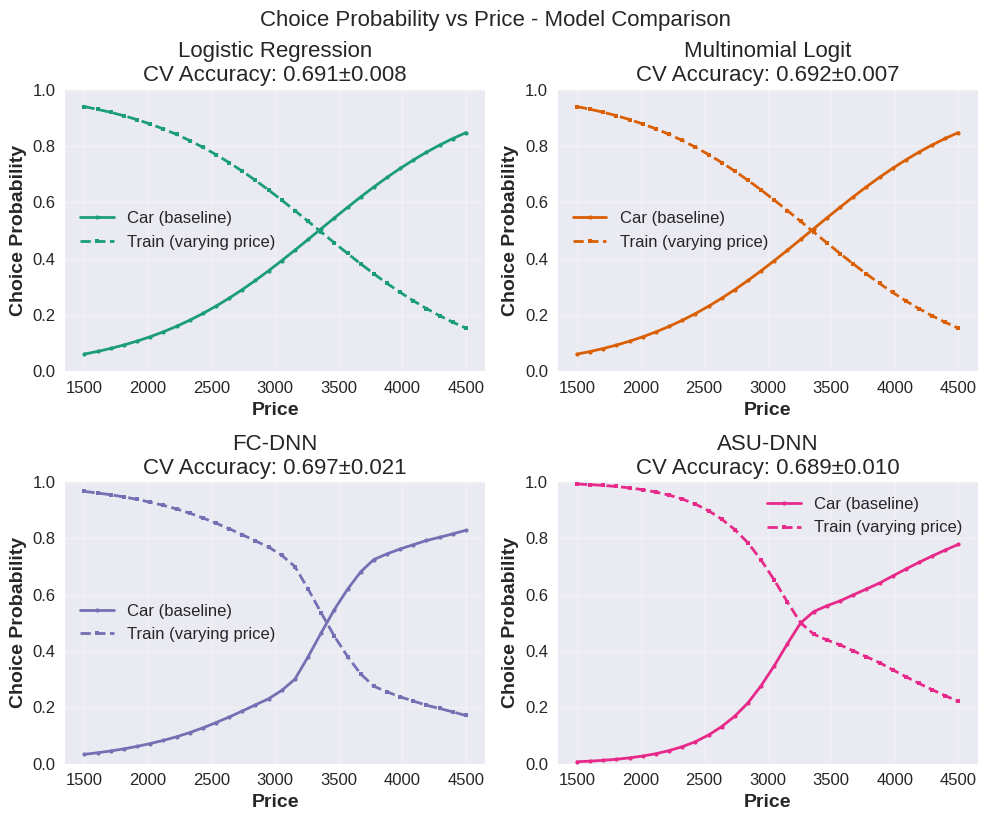

In [23]:
# Plot 1: Choice probabilities vs Price
print("\n1. Price Sensitivity Analysis...")
plot_choice_probabilities_all_models(
    visualization_models,
    feature_name='price',
    feature_values=np.linspace(1500, 4500, 30)
)


2. Travel Time Sensitivity Analysis...


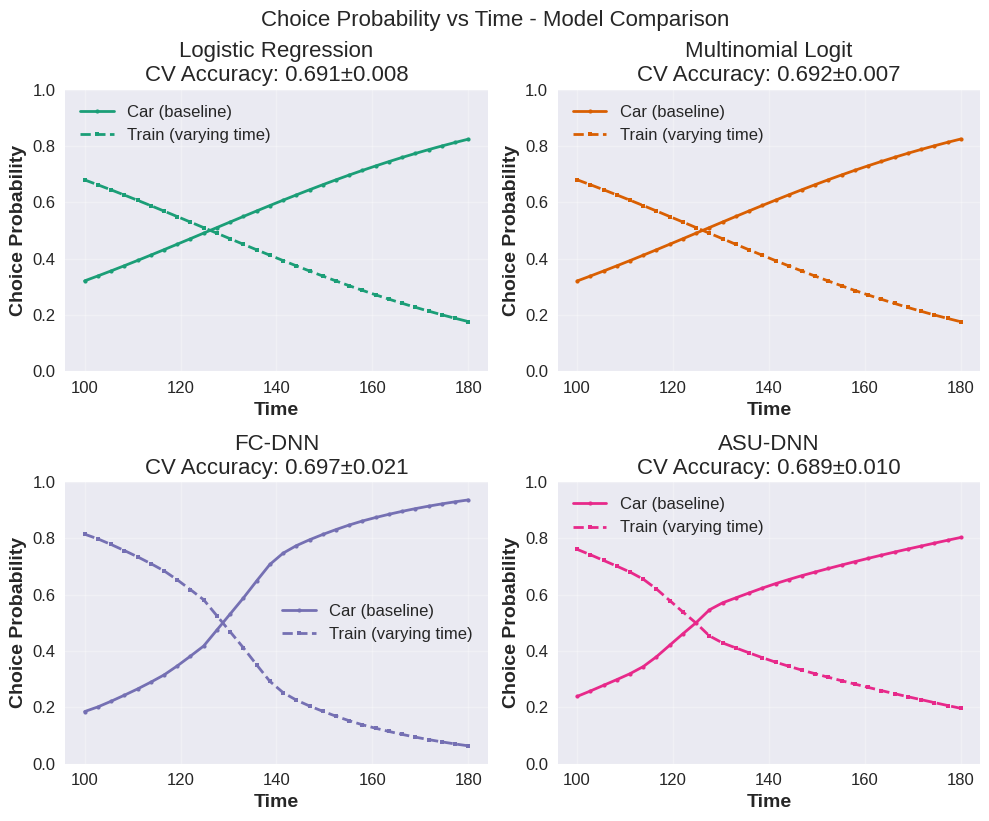

In [24]:
# Plot 2: Choice probabilities vs Travel Time
print("\n2. Travel Time Sensitivity Analysis...")
plot_choice_probabilities_all_models(
    visualization_models,
    feature_name='time',
    feature_values=np.linspace(100, 180, 30)
)

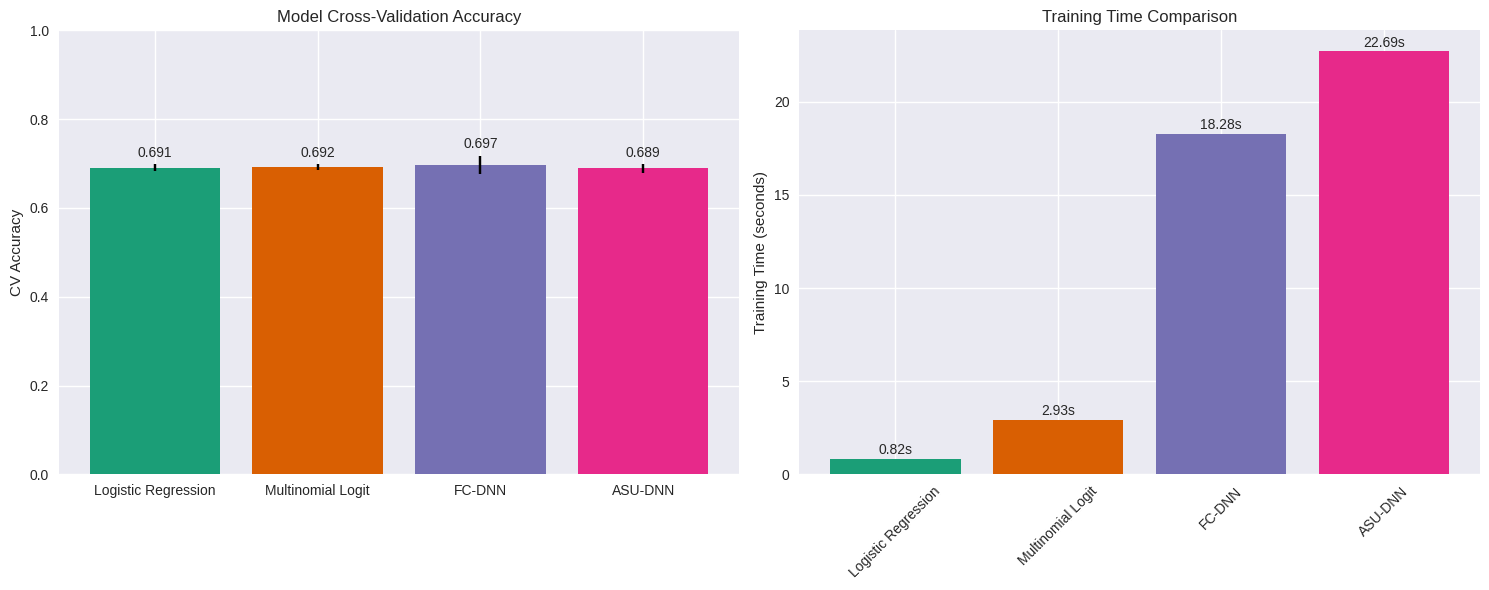


Detailed Model Comparison:
Model                CV Accuracy     Training Time   Relative Performance
----------------------------------------------------------------------
Logistic Regression  0.691 ± 0.008   0.82s           99.2%               
Multinomial Logit    0.692 ± 0.007   2.93s           99.3%               
FC-DNN               0.697 ± 0.021   18.28s          100.0%              
ASU-DNN              0.689 ± 0.010   22.69s          98.9%               


In [25]:
# Create performance comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
model_names = list(visualization_models.keys())
accuracies = [visualization_models[name]['accuracy'] for name in model_names]
accuracy_stds = [visualization_models[name]['accuracy_std'] for name in model_names]
training_times = [visualization_models[name]['training_time'] for name in model_names]

bars1 = ax1.bar(model_names, accuracies, yerr=accuracy_stds, capsize=5,
                color=plt.get_cmap("Dark2").colors[:4])
ax1.set_ylabel('CV Accuracy')
ax1.set_title('Model Cross-Validation Accuracy')
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc, std in zip(bars1, accuracies, accuracy_stds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
            f'{acc:.3f}', ha='center', va='bottom')

# Training time comparison
bars2 = ax2.bar(model_names, training_times, color=plt.get_cmap("Dark2").colors[:4])
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')

# Add value labels on bars
for bar, training_time in zip(bars2, training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{training_time:.2f}s', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Model Comparison:")
print(f"{'Model':<20} {'CV Accuracy':<15} {'Training Time':<15} {'Relative Performance':<20}")
print("-" * 70)

max_acc = max(accuracies)
for name, acc, std, training_time in zip(model_names, accuracies, accuracy_stds, training_times):
    rel_perf = f"{acc/max_acc*100:.1f}%"
    acc_str = f"{acc:.3f} ± {std:.3f}"
    time_str = f"{training_time:.2f}s"
    print(f"{name:<20} {acc_str:<15} {time_str:<15} {rel_perf:<20}")

### MNL Parameters
Finally, we will take a look at the MNL parameters (betas), which allow us to understand the relationships within the data:

In [26]:
m = visualization_models['Multinomial Logit']['model']
m.summary()

MULTINOMIAL LOGIT (MNL) MODEL SUMMARY
Log-Likelihood = -1723.837
AIC = 3457.67 | BIC = 3491.05
------------------------------------------------------------
Parameters:
Parameter  Estimate
   ASC[2] -0.032498
       x0 -1.908640
       x1 -0.820926
       x2 -0.576485
       x3 -0.240370


### Examinin the MNL Coefficients
Recall that in MNL the utility of alternative $j$ is

$$
U_j \;=\; \beta_{\text{price}}\, \text{price}_j
      + \beta_{\text{time}}\, \text{time}_j
      + \beta_{\text{comfort}}\, \text{comfort}_j
      + \beta_{\text{change}}\, \text{change}_j
      + \text{ASC}_j
      + \varepsilon_j
$$
- **ASC[Train or j=2] = -0.0325**  
  Very close to 0. This is the constant shift for **Train** relative to the base alternative **Car**. It indicates there is essentially no inherent preference for train over car once observed attributes are controlled for.

- **price = -1.91**  
  Strongly negative. A higher **train fare** substantially reduces the probability of choosing train, and the magnitude is the largest among all coefficients — price is the most influential factor in mode choice.

- **time = -0.82**  
  Negative, as expected: longer **train travel time** decreases the likelihood of choosing train. Its effect is about half the size of the price coefficient (on the normalized scale).

- **comfort = -0.58**  
  At first glance surprising: if larger values meant *more comfort*, we would expect a positive coefficient. Since the sign is negative, this suggests that in the dataset a larger “comfort” value actually means *less comfort* (e.g., higher number = less desirable comfort). It is worth double-checking the coding.

- **change = -0.24**  
  Negative: more **train transfers** reduce the probability of choosing train, but the effect is smaller in magnitude than price or time. This suggests people dislike transfers, but not as strongly as they dislike higher fares or longer travel time.

#### In Short
- **Train fare dominates**: higher ticket prices strongly deter rail use.  
- **Train travel time also matters**, but somewhat less than fare.  
- **Comfort and transfers matter**, but they are secondary compared to price and time.  
- **No strong inherent bias** between train and car once attributes are accounted for (ASC ≈ 0).

## Conclusions and Key Insights

In this exercise, we explored discrete choice modeling from three complementary perspectives: the **theory-driven** (logistic regression, multinomial logit), the **data-driven** (fully connected deep neural network, FC-DNN), and their **hybrid** (alternative-specific utility DNN, ASU-DNN). We began by loading and inspecting a Rail vs. Car mode choice dataset from the Netherlands, which captures trade-offs between ticket price, travel time, comfort, and number of transfers.

We then specified and trained four models: two classical baselines (logistic regression and multinomial logit) and two neural network-based approaches (FC-DNN and ASU-DNN). The ASU-DNN in particular provided a way to integrate domain structure from random utility theory while still leveraging the flexibility of deep learning.

To assess model performance, we implemented a 5-fold cross-validation routine, ensuring that results were robust across different splits of the data. Beyond raw accuracy, we also examined model outputs by plotting predicted choice probabilities against varying train attributes while keeping car fixed as the baseline. These visualizations offered intuitive insights into substitution patterns, highlighting, for example, how increases in train fare or travel time shift choice probabilities toward car.

Overall, the results confirm that **price and time are the dominant factors** driving the car-train mode choice, with comfort and transfers playing secondary but still meaningful roles. Importantly, the models show **no strong inherent bias** toward either mode once these observed attributes are accounted for. The comparison across models illustrates how classical econometric methods and modern neural architectures can complement each other: the former offering interpretability grounded in theory, the latter providing flexibility to capture nonlinearities, and the hybrid ASU-DNN bridging the two worlds.

### Model Comparison Summary

| Aspect | MNL | FC-DNN | ASU-DNN |
|--------|-----|---------|---------|
| **Interpretability** | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐⭐ |
| **Flexibility** | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ |
| **Theoretical Foundation** | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Data Requirements** | ⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐ |
| **Training Speed** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ |

### Key Findings

1. **Multinomial Logit (MNL)**:
   - Provides clear, interpretable parameter estimates
   - Fast training and prediction
   - Strong theoretical foundation in Random Utility Theory
   - Limited by linear utility assumptions

2. **Fully Connected DNN (FC-DNN)**:
   - Can capture complex non-linear relationships
   - May achieve higher accuracy on complex datasets
   - Less interpretable than traditional models
   - Risk of overfitting with limited data

3. **Alternative-Specific Utility DNN (ASU-DNN)**:
   - Combines flexibility of neural networks with choice theory
   - Maintains interpretable utility structure
   - Can model alternative-specific preferences
   - Best balance between accuracy and interpretability

### Practical Recommendations

**When to use MNL:**
- Need highly interpretable results for policy analysis
- Limited computational resources
- Well-understood linear relationships
- Regulatory requirements for explainable models

**When to use FC-DNN:**
- Large datasets with complex patterns
- Prediction accuracy is primary goal
- Non-linear relationships suspected
- Computational resources available

**When to use ASU-DNN:**
- Need both accuracy and interpretability
- Different alternatives have distinct choice processes
- Want to maintain choice theory foundations
- Sufficient data for stable estimation

### Transportation Applications

These models are particularly valuable for:

- **Route Choice Modeling**: Understanding how travelers select routes
- **Mode Choice Analysis**: Predicting transportation mode preferences
- **Service Design**: Optimizing transportation service attributes
- **Policy Evaluation**: Assessing impact of transportation policies

### Future Directions

1. **Hybrid Models**: Combining interpretable linear components with flexible neural networks
2. **Attention Mechanisms**: Understanding which attributes matter most for different choice contexts
3. **Transfer Learning**: Applying models trained on one context to similar problems
4. **Uncertainty Quantification**: Providing confidence intervals for predictions

# Acknowledgements

Course TA:
- Riccardo Fiorista ([LinkedIn](https://www.linkedin.com/in/riccardo-fiorista))

Recitation credits:
- Shenhao Wang ([LinkedIn](https://www.linkedin.com/in/shenhao-wang-9ab76256/))
- Haris N. Koutsopoulos ([LinkedIn](https://www.linkedin.com/in/haris-n-koutsopoulos-6973a633/))
- Prunelle Vogler ([LinkedIn](https://www.linkedin.com/in/prunelle-vogler/))

Based on the work:
- [Deep neural networks for choice analysis: Architecture design with alternative-specific utility functions](https://doi.org/10.1016/j.trc.2020.01.012) by *Shenhao Wang*, *Baichuan Mo*, *Jinhua Zhao*
- <u>NestGNN: A Graph Neural Network Framework Generalizing the Nested Logit Model for Travel Mode Choice</u> by *Yuqi Zhou*, *Zhanhong Cheng*, *Lingqian Hu*, *Yuheng Bu*, *Shenhao Wang*

*Disclaimer: Generative AI has been used to create or adapt parts of this recitation.*